# BoVW experimentation

Team 6
* Gerard Vilaplana
* Adrià Ruiz
* Aleix Armero
* Arnau Marcos
* Lore Oregi

# Introduction

The experimentation pipeline will be the following: We'll take a baseline configuration detailed below, and we're going to perform experiments in diferent aspects of the whole pipeline. As we make those experiments, we'll update the baseline keeping the balance with the best results from the previous experiments and hyperparameters that don't compromise the experimentation speed. We're going to use the following baseline for experimentation:
- Descriptor: SIFT, as the common algorithm for feature extraction in classic literature
- Number of features: 500
- Size of codebook: 512 (For initial fast clustering experimentation)
- Normalization: L2 in histograms
- Spatial Pyramids: No pyramid (no level)
- Dimensionality reuction: None (first we try with the whole data)
- Classifier: Logistic Regression (fast and easy hyperparameters for base experimentation)


With this pipeline, we're going to try:
- Number of local features in descriptors
- SIFT / AKAZE / ORB / Dense SIFT
- Spatial pyramids vs no spatial pyramids
- Try normalization and scale
- Size of codebook
- Try dimensionality reduction
- Classifiers: Logistic Regression vs SVM vs KNN
- Fisher Vectors

All experiments are evaluated using stratified 5-fold cross-validation to ensure reliable and consistent performance results.


In [2]:
from main import *
from bovw import *

import os
import random
import numpy as np
import pandas as pd


%matplotlib inline
from matplotlib import pyplot as plt

In [3]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)

# Dataset Overview

In [4]:
data_train = Dataset(ImageFolder="../data/places_reduced/train")
data_test = Dataset(ImageFolder="../data/places_reduced/val")

len(data_train), len(data_test)

(8700, 2200)

In [5]:
train_sizes = set([img.size for img, _ in data_train])
print("Train unique sizes:", train_sizes)

test_sizes = set([img.size for img, _ in data_test])
print("Test unique sizes:", test_sizes)

Train unique sizes: {(256, 256)}
Test unique sizes: {(256, 256)}


In [8]:
random.shuffle(data_train)
random.shuffle(data_test)

5


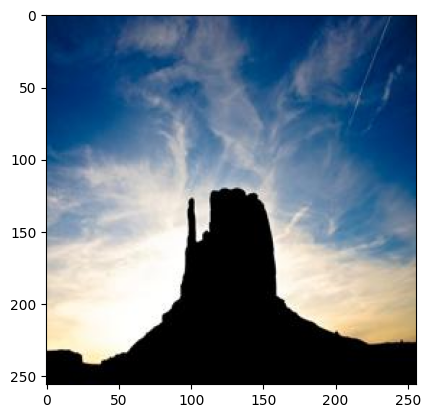

In [9]:
sample_idx = 70
print(data_train[sample_idx][1])
plt.imshow(np.array(data_train[sample_idx][0]))
plt.show()

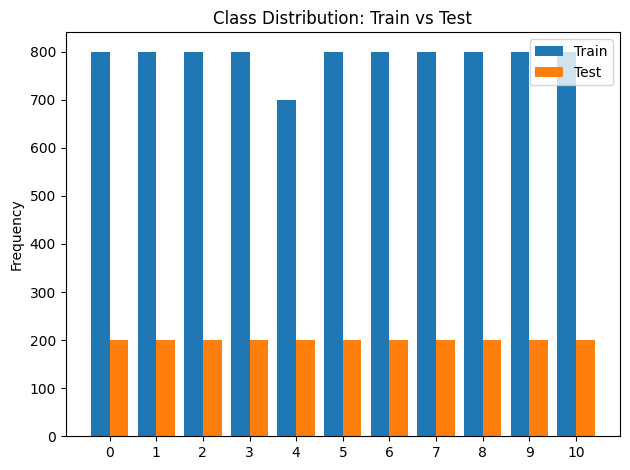

In [10]:
train_class_counter = Counter(entry[1] for entry in data_train)
test_class_counter = Counter(entry[1] for entry in data_test)

classes = sorted(train_class_counter.keys())  # or union with test if needed
train_counts = [train_class_counter[c] for c in classes]
test_counts = [test_class_counter[c] for c in classes]

width = 0.4
x = range(len(classes))

plt.bar([xi - width/2 for xi in x], train_counts, width=width, label="Train")
plt.bar([xi + width/2 for xi in x], test_counts, width=width, label="Test")

plt.xticks(x, classes)
plt.ylabel("Frequency")
plt.title("Class Distribution: Train vs Test")
plt.legend()
plt.tight_layout()
plt.show()

All classes have 800 training images except for class 4 ("industrial and construction"), which has 700.

All classes have 200 test samples.

# Experiments

In [ ]:
#Execution example:
"""
bovw_params = {
    "detector_type": "DSIFT",
    "codebook_size": 100, 
    "detector_kwargs": {"nfeatures": 100},
    "dense_kwargs": {"step": 16, "size": 16}
}

classifier_cls = SVC
classifier_params = {
    "kernel": 'rbf', 
}

scores = cross_validate_bovw(
    data_train,
    bovw_kwargs=bovw_params,
    classifier_cls=classifier_cls,
    classifier_kwargs=classifier_params
)

scores.test.accuracy.mean
"""

'\nbovw_params = {\n    "detector_type": "DSIFT",\n    "codebook_size": 100, \n    "detector_kwargs": {"nfeatures": 100},\n    "dense_kwargs": {"step": 16, "size": 16}\n}\n\nclassifier_cls = SVC\nclassifier_params = {\n    "kernel": \'rbf\', \n}\n\nscores = cross_validate_bovw(\n    data_train,\n    bovw_kwargs=bovw_params,\n    classifier_cls=classifier_cls,\n    classifier_kwargs=classifier_params\n)\n\nscores.test.accuracy.mean\n'

## A) Descriptors (SIFT vs AKAZE vs ORB) and number of features

In this first experiment, we analyze how the number of extracted local features and the specific descriptor used influence the performance of the classification pipeline. We seek to answer the following questions:

* How does increasing or reducing the number of local features affect accuracy?

* To what extent does the type of descriptor (SIFT, AKAZE, ORB) impact the final performance?

For AKAZE, the number of extracted keypoints is not directly controlled through a parameter like in SIFT or ORB. Instead, we vary the detector threshold, which indirectly regulates keypoint density: lower thresholds produce more local features, while higher thresholds result in fewer and more selective keypoints.

In [11]:
enable_cache()

### SIFT

In [19]:
# SIFT
print("TESTING SIFT DESCRIPTOR")

sift_nfeatures = [250, 500, 1000, 2000, 10000]
sift_results = {}

for nfeatures in sift_nfeatures:
    print(f"\nSIFT with nfeatures={nfeatures}")
    
    bovw_params = {
        "detector_type": "SIFT",
        "codebook_size": 512,
        "detector_kwargs": {"nfeatures": nfeatures},
    }
    
    classifier_cls = LogisticRegression
    classifier_params = {
        "max_iter": 1000,
        "class_weight": "balanced",
    }
    
    scores = cross_validate_bovw(
        data_train,
        bovw_kwargs=bovw_params,
        classifier_cls=classifier_cls,
        classifier_kwargs=classifier_params,
        n_splits=5,
        verbose=False,
    )
    
    sift_results[nfeatures] = scores
    
    print(f"[SIFT nfeatures={nfeatures}] Results:")
    print(f"  Train Accuracy:  {scores.train.accuracy.mean:.4f} ± {scores.train.accuracy.std:.4f}")
    print(f"  Test Accuracy:   {scores.test.accuracy.mean:.4f} ± {scores.test.accuracy.std:.4f}")
    print(f"  Test Precision:  {scores.test.precision.mean:.4f} ± {scores.test.precision.std:.4f}")
    print(f"  Test Recall:     {scores.test.recall.mean:.4f} ± {scores.test.recall.std:.4f}")
    print(f"  Test F1-Score:   {scores.test.f1.mean:.4f} ± {scores.test.f1.std:.4f}")


print("\nSIFT SUMMARY")
for nfeatures in sift_nfeatures:
    print(f"nfeatures={nfeatures:4d} -> Accuracy Train: {sift_results[nfeatures].train.accuracy.mean:.4f} ± {sift_results[nfeatures].train.accuracy.std:.4f}")
    print(f"nfeatures={nfeatures:4d} -> Accuracy Test: {sift_results[nfeatures].test.accuracy.mean:.4f} ± {sift_results[nfeatures].test.accuracy.std:.4f}")
    print("")

TESTING SIFT DESCRIPTOR

SIFT with nfeatures=250


Phase [Setup]: Extracting the descriptors:   6%|▋         | 553/8700 [00:00<00:08, 1008.54it/s]

Could not compute descriptors for image ../data/places_reduced/train/water_ice_snow/iceberg_00000023.jpg of class 9.


Phase [Setup]: Extracting the descriptors:  13%|█▎        | 1119/8700 [00:01<00:08, 888.76it/s] 

Could not compute descriptors for image ../data/places_reduced/train/mountains_hills_desert_sky/sky_00001410.jpg of class 5.


100%|██████████| 5/5 [02:19<00:00, 27.93s/it]


[SIFT nfeatures=250] Results:
  Train Accuracy:  0.4361 ± 0.0052
  Test Accuracy:   0.2929 ± 0.0085
  Test Precision:  0.2841 ± 0.0082
  Test Recall:     0.2929 ± 0.0085
  Test F1-Score:   0.2855 ± 0.0079

SIFT with nfeatures=500


Phase [Setup]: Extracting the descriptors:   6%|▌         | 524/8700 [00:01<00:25, 324.68it/s]

Could not compute descriptors for image ../data/places_reduced/train/water_ice_snow/iceberg_00000023.jpg of class 9.


Phase [Setup]: Extracting the descriptors:  12%|█▏        | 1056/8700 [00:02<00:16, 473.35it/s]

Could not compute descriptors for image ../data/places_reduced/train/mountains_hills_desert_sky/sky_00001410.jpg of class 5.


100%|██████████| 5/5 [02:56<00:00, 35.27s/it]


[SIFT nfeatures=500] Results:
  Train Accuracy:  0.4423 ± 0.0032
  Test Accuracy:   0.3181 ± 0.0048
  Test Precision:  0.3101 ± 0.0050
  Test Recall:     0.3181 ± 0.0048
  Test F1-Score:   0.3106 ± 0.0047

SIFT with nfeatures=1000


Phase [Setup]: Extracting the descriptors:   7%|▋         | 567/8700 [00:01<00:13, 621.24it/s]

Could not compute descriptors for image ../data/places_reduced/train/water_ice_snow/iceberg_00000023.jpg of class 9.


Phase [Setup]: Extracting the descriptors:  12%|█▏        | 1071/8700 [00:01<00:14, 537.33it/s]

Could not compute descriptors for image ../data/places_reduced/train/mountains_hills_desert_sky/sky_00001410.jpg of class 5.


100%|██████████| 5/5 [03:54<00:00, 46.92s/it]


[SIFT nfeatures=1000] Results:
  Train Accuracy:  0.4482 ± 0.0068
  Test Accuracy:   0.3324 ± 0.0073
  Test Precision:  0.3234 ± 0.0081
  Test Recall:     0.3324 ± 0.0073
  Test F1-Score:   0.3245 ± 0.0084

SIFT with nfeatures=2000


Phase [Setup]: Extracting the descriptors:   6%|▌         | 496/8700 [00:00<00:15, 530.05it/s]

Could not compute descriptors for image ../data/places_reduced/train/water_ice_snow/iceberg_00000023.jpg of class 9.


Phase [Setup]: Extracting the descriptors:  12%|█▏        | 1069/8700 [00:02<00:22, 331.90it/s]

Could not compute descriptors for image ../data/places_reduced/train/mountains_hills_desert_sky/sky_00001410.jpg of class 5.


100%|██████████| 5/5 [03:50<00:00, 46.07s/it]


[SIFT nfeatures=2000] Results:
  Train Accuracy:  0.4462 ± 0.0027
  Test Accuracy:   0.3315 ± 0.0082
  Test Precision:  0.3215 ± 0.0094
  Test Recall:     0.3315 ± 0.0082
  Test F1-Score:   0.3227 ± 0.0085

SIFT with nfeatures=10000


Phase [Setup]: Extracting the descriptors:   6%|▌         | 505/8700 [00:19<05:36, 24.39it/s]

Could not compute descriptors for image ../data/places_reduced/train/water_ice_snow/iceberg_00000023.jpg of class 9.


Phase [Setup]: Extracting the descriptors:  12%|█▏        | 1029/8700 [00:37<05:04, 25.18it/s]

Could not compute descriptors for image ../data/places_reduced/train/mountains_hills_desert_sky/sky_00001410.jpg of class 5.


100%|██████████| 5/5 [03:50<00:00, 46.13s/it]

[SIFT nfeatures=10000] Results:
  Train Accuracy:  0.4519 ± 0.0035
  Test Accuracy:   0.3275 ± 0.0037
  Test Precision:  0.3202 ± 0.0037
  Test Recall:     0.3275 ± 0.0037
  Test F1-Score:   0.3202 ± 0.0036

SIFT SUMMARY
nfeatures= 250 -> Accuracy Train: 0.4361 ± 0.0052
nfeatures= 250 -> Accuracy Test: 0.2929 ± 0.0085

nfeatures= 500 -> Accuracy Train: 0.4423 ± 0.0032
nfeatures= 500 -> Accuracy Test: 0.3181 ± 0.0048

nfeatures=1000 -> Accuracy Train: 0.4482 ± 0.0068
nfeatures=1000 -> Accuracy Test: 0.3324 ± 0.0073

nfeatures=2000 -> Accuracy Train: 0.4462 ± 0.0027
nfeatures=2000 -> Accuracy Test: 0.3315 ± 0.0082

nfeatures=10000 -> Accuracy Train: 0.4519 ± 0.0035
nfeatures=10000 -> Accuracy Test: 0.3275 ± 0.0037



SIFT SUMMARY
- nfeatures= 250 -> Accuracy Train: 0.4361 ± 0.0052
- nfeatures= 250 -> Accuracy Test: 0.2929 ± 0.0085

- nfeatures= 500 -> Accuracy Train: 0.4423 ± 0.0032
- nfeatures= 500 -> Accuracy Test: 0.3181 ± 0.0048

- nfeatures=1000 -> Accuracy Train: 0.4482 ± 0.0068
- nfeatures=1000 -> Accuracy Test: 0.3324 ± 0.0073

- nfeatures=2000 -> Accuracy Train: 0.4462 ± 0.0027
- nfeatures=2000 -> Accuracy Test: 0.3315 ± 0.0082

- nfeatures=10000 -> Accuracy Train: 0.4519 ± 0.0035
- nfeatures=10000 -> Accuracy Test: 0.3275 ± 0.0037


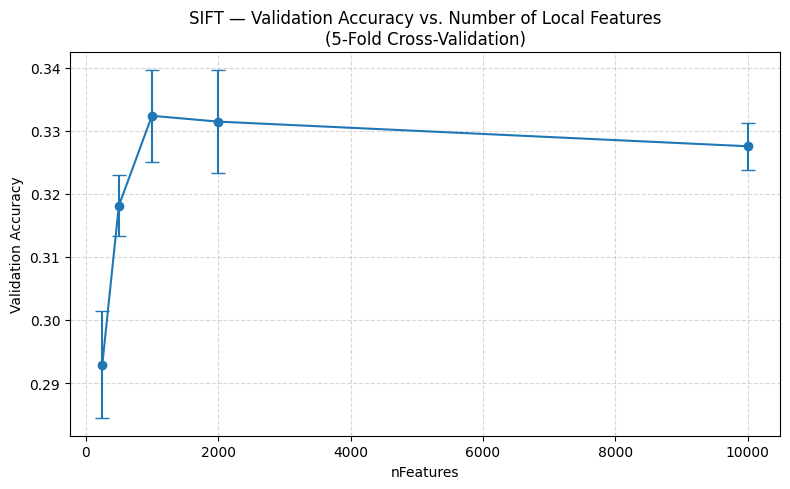

In [20]:
# Plot SIFT Validation Accuracy vs nFeatures (5-Fold CV)

# Since the dataset is reasonably balanced and we use stratified 5-fold cross-validation, 
# accuracy is a reliable metric for evaluating performance in this experiment.

n_features = sift_nfeatures

# Accuracy
acc_means = [sift_results[n].test.accuracy.mean for n in n_features]
acc_stds  = [sift_results[n].test.accuracy.std for n in n_features]

plt.figure(figsize=(8, 5))
plt.errorbar(n_features, acc_means, yerr=acc_stds,
             marker='o', capsize=5)

plt.title("SIFT — Validation Accuracy vs. Number of Local Features\n(5-Fold Cross-Validation)")
plt.xlabel("nFeatures")
plt.ylabel("Validation Accuracy")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


In [24]:
# Tested on the held-out test set using the best nFeatures selected by cross-validation (1000)
bovw_params = {
    "detector_type": "SIFT",
    "codebook_size": 512,
    "detector_kwargs": {"nfeatures": 1000},
}

classifier_cls = LogisticRegression
classifier_params = {
    "max_iter": 1000,
    "class_weight": "balanced",
}
bovw = BOVW(**bovw_params)
classifier = classifier_cls(**classifier_params)
bovw, classifier = train(dataset=data_train, bovw=bovw, classifier=classifier)

test(dataset=data_test, bovw=bovw, classifier=classifier)

Phase [Training]: Extracting the descriptors: 100%|██████████| 8700/8700 [00:17<00:00, 492.94it/s]


Fitting the codebook
Computing the bovw histograms
Fitting the classifier
Accuracy on Phase[Train]: 0.4394113589330881
Precision on Phase[Train]: 0.4354166017153769
Recall on Phase[Train]: 0.4394113589330881
F1-Score on Phase[Train]: 0.4341451799256469


Phase [Eval]: Extracting the descriptors: 100%|██████████| 2200/2200 [01:23<00:00, 26.28it/s]


Computing the bovw histograms
predicting the values
Accuracy on Phase[Test]: 0.32181818181818184
Precision on Phase[Test]: 0.3091215396807147
Recall on Phase[Test]: 0.32181818181818184
F1-Score on Phase[Test]: 0.31138646851653906


(0.32181818181818184,
 0.3091215396807147,
 0.32181818181818184,
 0.31138646851653906)

### AKAZE

In [13]:
# AKAZE
print("TESTING AKAZE DESCRIPTOR")

akaze_threshold = [0.0004, 0.0008, 0.0012]
akaze_results = {}

for thr in akaze_threshold:
    print(f"\nAKAZE with threshold={thr}")
    
    bovw_params = {
        "detector_type": "AKAZE",
        "codebook_size": 512,
        "detector_kwargs": {"threshold": thr},
    }
    
    classifier_cls = LogisticRegression
    classifier_params = {
        "max_iter": 1000,
        "class_weight": "balanced",
    }
    
    scores = cross_validate_bovw(
        data_train,
        bovw_kwargs=bovw_params,
        classifier_cls=classifier_cls,
        classifier_kwargs=classifier_params,
        n_splits=5,
        verbose=False,
    )
    
    akaze_results[thr] = scores
    
    print(f"[AKAZE threshold={thr}] Results:")
    print(f"  Train Accuracy:  {scores.train.accuracy.mean:.4f} ± {scores.train.accuracy.std:.4f}")
    print(f"  Test Accuracy:   {scores.test.accuracy.mean:.4f} ± {scores.test.accuracy.std:.4f}")
    print(f"  Test Precision:  {scores.test.precision.mean:.4f} ± {scores.test.precision.std:.4f}")
    print(f"  Test Recall:     {scores.test.recall.mean:.4f} ± {scores.test.recall.std:.4f}")
    print(f"  Test F1-Score:   {scores.test.f1.mean:.4f} ± {scores.test.f1.std:.4f}")

print("\nAKAZE SUMMARY")
for thr in akaze_threshold:
    print(f"thr={thr} -> Accuracy Train: {akaze_results[thr].train.accuracy.mean:.4f} ± {akaze_results[thr].train.accuracy.std:.4f}")
    print(f"thr={thr} -> Accuracy Test: {akaze_results[thr].test.accuracy.mean:.4f} ± {akaze_results[thr].test.accuracy.std:.4f}")
    print("")

TESTING AKAZE DESCRIPTOR

AKAZE with threshold=0.0004


Phase [Setup]: Extracting the descriptors:   0%|          | 0/8700 [00:00<?, ?it/s]

Phase [Setup]: Extracting the descriptors:   6%|▋         | 556/8700 [00:01<00:16, 502.40it/s]

Could not compute descriptors for image ../data/places_reduced/train/water_ice_snow/iceberg_00000023.jpg of class 9.


Phase [Setup]: Extracting the descriptors:  12%|█▏        | 1085/8700 [00:01<00:09, 811.48it/s]

Could not compute descriptors for image ../data/places_reduced/train/mountains_hills_desert_sky/sky_00001410.jpg of class 5.


Phase [Setup]: Extracting the descriptors:  45%|████▌     | 3950/8700 [00:06<00:10, 473.18it/s] 

Could not compute descriptors for image ../data/places_reduced/train/mountains_hills_desert_sky/volcano_00004486.jpg of class 5.


Phase [Setup]: Extracting the descriptors:  66%|██████▌   | 5730/8700 [00:08<00:02, 1043.05it/s]

Could not compute descriptors for image ../data/places_reduced/train/sports and leisure/sauna_00001030.jpg of class 7.


Phase [Setup]: Extracting the descriptors:  76%|███████▌  | 6626/8700 [00:09<00:02, 825.86it/s] 

Could not compute descriptors for image ../data/places_reduced/train/mountains_hills_desert_sky/canyon_00003418.jpg of class 5.


Phase [Setup]: Extracting the descriptors:  86%|████████▌ | 7440/8700 [00:10<00:01, 1173.65it/s]

Could not compute descriptors for image ../data/places_reduced/train/mountains_hills_desert_sky/sky_00001057.jpg of class 5.


Phase [Setup]: Extracting the descriptors:  90%|████████▉ | 7816/8700 [00:10<00:00, 1166.65it/s]

Could not compute descriptors for image ../data/places_reduced/train/sports and leisure/sauna_00003623.jpg of class 7.


100%|██████████| 5/5 [02:48<00:00, 33.62s/it]


[AKAZE threshold=0.0004] Results:
  Train Accuracy:  0.3682 ± 0.0038
  Test Accuracy:   0.2182 ± 0.0085
  Test Precision:  0.2140 ± 0.0082
  Test Recall:     0.2182 ± 0.0085
  Test F1-Score:   0.2134 ± 0.0076

AKAZE with threshold=0.0008


Phase [Setup]: Extracting the descriptors:   6%|▌         | 514/8700 [00:08<02:18, 59.06it/s]

Could not compute descriptors for image ../data/places_reduced/train/water_ice_snow/iceberg_00000023.jpg of class 9.


Phase [Setup]: Extracting the descriptors:  12%|█▏        | 1037/8700 [00:18<02:09, 59.28it/s]

Could not compute descriptors for image ../data/places_reduced/train/mountains_hills_desert_sky/sky_00001410.jpg of class 5.


Phase [Setup]: Extracting the descriptors:  28%|██▊       | 2429/8700 [00:43<01:44, 60.05it/s]

Could not compute descriptors for image ../data/places_reduced/train/mountains_hills_desert_sky/sky_00004426.jpg of class 5.


Phase [Setup]: Extracting the descriptors:  36%|███▌      | 3121/8700 [00:56<01:37, 56.93it/s]

Could not compute descriptors for image ../data/places_reduced/train/mountains_hills_desert_sky/mountain_00002707.jpg of class 5.


Phase [Setup]: Extracting the descriptors:  40%|████      | 3497/8700 [01:03<01:26, 59.84it/s]

Could not compute descriptors for image ../data/places_reduced/train/mountains_hills_desert_sky/sky_00000137.jpg of class 5.


Phase [Setup]: Extracting the descriptors:  45%|████▌     | 3935/8700 [01:11<01:21, 58.80it/s]

Could not compute descriptors for image ../data/places_reduced/train/mountains_hills_desert_sky/volcano_00004486.jpg of class 5.


Phase [Setup]: Extracting the descriptors:  59%|█████▉    | 5131/8700 [01:33<01:00, 59.20it/s]

Could not compute descriptors for image ../data/places_reduced/train/forest_field_jungle/pasture_00002164.jpg of class 1.


Phase [Setup]: Extracting the descriptors:  62%|██████▏   | 5418/8700 [01:39<00:50, 64.91it/s]

Could not compute descriptors for image ../data/places_reduced/train/mountains_hills_desert_sky/cliff_00001485.jpg of class 5.


Phase [Setup]: Extracting the descriptors:  64%|██████▍   | 5610/8700 [01:43<01:21, 37.98it/s]

Could not compute descriptors for image ../data/places_reduced/train/sports and leisure/sauna_00001030.jpg of class 7.


Phase [Setup]: Extracting the descriptors:  71%|███████   | 6186/8700 [01:54<00:40, 61.49it/s]

Could not compute descriptors for image ../data/places_reduced/train/mountains_hills_desert_sky/cliff_00001932.jpg of class 5.


Phase [Setup]: Extracting the descriptors:  76%|███████▌  | 6598/8700 [02:01<00:41, 50.77it/s]

Could not compute descriptors for image ../data/places_reduced/train/mountains_hills_desert_sky/canyon_00003418.jpg of class 5.


Phase [Setup]: Extracting the descriptors:  78%|███████▊  | 6812/8700 [02:05<00:40, 46.42it/s]

Could not compute descriptors for image ../data/places_reduced/train/mountains_hills_desert_sky/sky_00000226.jpg of class 5.


Phase [Setup]: Extracting the descriptors:  83%|████████▎ | 7200/8700 [02:12<00:26, 57.28it/s]

Could not compute descriptors for image ../data/places_reduced/train/mountains_hills_desert_sky/sky_00001057.jpg of class 5.


Phase [Setup]: Extracting the descriptors:  89%|████████▊ | 7705/8700 [02:22<00:15, 64.32it/s]

Could not compute descriptors for image ../data/places_reduced/train/sports and leisure/sauna_00003623.jpg of class 7.


100%|██████████| 5/5 [02:20<00:00, 28.15s/it]


[AKAZE threshold=0.0008] Results:
  Train Accuracy:  0.3658 ± 0.0054
  Test Accuracy:   0.1962 ± 0.0104
  Test Precision:  0.1906 ± 0.0110
  Test Recall:     0.1962 ± 0.0104
  Test F1-Score:   0.1912 ± 0.0106

AKAZE with threshold=0.0012


Phase [Setup]: Extracting the descriptors:   6%|▌         | 515/8700 [00:09<02:13, 61.35it/s]

Could not compute descriptors for image ../data/places_reduced/train/water_ice_snow/iceberg_00000023.jpg of class 9.


Phase [Setup]: Extracting the descriptors:  12%|█▏        | 1036/8700 [00:17<02:03, 62.04it/s]

Could not compute descriptors for image ../data/places_reduced/train/mountains_hills_desert_sky/sky_00001410.jpg of class 5.


Phase [Setup]: Extracting the descriptors:  14%|█▍        | 1218/8700 [00:20<02:08, 58.16it/s]

Could not compute descriptors for image ../data/places_reduced/train/mountains_hills_desert_sky/sky_00003849.jpg of class 5.


Phase [Setup]: Extracting the descriptors:  15%|█▌        | 1307/8700 [00:22<02:10, 56.80it/s]

Could not compute descriptors for image ../data/places_reduced/train/home or hotel/bathroom_00000599.jpg of class 2.


Phase [Setup]: Extracting the descriptors:  18%|█▊        | 1582/8700 [00:26<01:54, 61.98it/s]

Could not compute descriptors for image ../data/places_reduced/train/water_ice_snow/hot_spring_00003968.jpg of class 9.


Phase [Setup]: Extracting the descriptors:  28%|██▊       | 2424/8700 [00:40<02:01, 51.83it/s]

Could not compute descriptors for image ../data/places_reduced/train/mountains_hills_desert_sky/sky_00004426.jpg of class 5.


Phase [Setup]: Extracting the descriptors:  29%|██▊       | 2500/8700 [00:42<02:20, 44.05it/s]

Could not compute descriptors for image ../data/places_reduced/train/sports_fields/promenade_00000058.jpg of class 8.


Phase [Setup]: Extracting the descriptors:  36%|███▌      | 3112/8700 [00:52<01:28, 63.23it/s]

Could not compute descriptors for image ../data/places_reduced/train/mountains_hills_desert_sky/mountain_00002707.jpg of class 5.


Phase [Setup]: Extracting the descriptors:  40%|████      | 3494/8700 [01:00<02:07, 40.87it/s]

Could not compute descriptors for image ../data/places_reduced/train/mountains_hills_desert_sky/sky_00000137.jpg of class 5.


Phase [Setup]: Extracting the descriptors:  45%|████▌     | 3927/8700 [01:08<01:59, 40.08it/s]

Could not compute descriptors for image ../data/places_reduced/train/mountains_hills_desert_sky/volcano_00004486.jpg of class 5.


Phase [Setup]: Extracting the descriptors:  53%|█████▎    | 4571/8700 [01:19<01:00, 67.76it/s]

Could not compute descriptors for image ../data/places_reduced/train/home or hotel/basement_00001438.jpg of class 2.


Phase [Setup]: Extracting the descriptors:  56%|█████▋    | 4914/8700 [01:24<00:58, 64.97it/s]

Could not compute descriptors for image ../data/places_reduced/train/sports and leisure/sauna_00003791.jpg of class 7.


Phase [Setup]: Extracting the descriptors:  59%|█████▉    | 5129/8700 [01:28<01:03, 56.46it/s]

Could not compute descriptors for image ../data/places_reduced/train/forest_field_jungle/pasture_00002164.jpg of class 1.


Phase [Setup]: Extracting the descriptors:  62%|██████▏   | 5412/8700 [01:33<01:03, 51.53it/s]

Could not compute descriptors for image ../data/places_reduced/train/mountains_hills_desert_sky/cliff_00001485.jpg of class 5.


Phase [Setup]: Extracting the descriptors:  64%|██████▍   | 5609/8700 [01:37<00:56, 54.31it/s]

Could not compute descriptors for image ../data/places_reduced/train/sports and leisure/sauna_00001030.jpg of class 7.


Phase [Setup]: Extracting the descriptors:  71%|███████   | 6178/8700 [01:47<00:50, 49.67it/s]

Could not compute descriptors for image ../data/places_reduced/train/mountains_hills_desert_sky/cliff_00001932.jpg of class 5.


Phase [Setup]: Extracting the descriptors:  74%|███████▍  | 6424/8700 [01:52<00:50, 44.66it/s]

Could not compute descriptors for image ../data/places_reduced/train/mountains_hills_desert_sky/volcano_00000431.jpg of class 5.


Phase [Setup]: Extracting the descriptors:  74%|███████▍  | 6464/8700 [01:52<00:50, 44.59it/s]

Could not compute descriptors for image ../data/places_reduced/train/mountains_hills_desert_sky/volcano_00002718.jpg of class 5.


Phase [Setup]: Extracting the descriptors:  76%|███████▌  | 6599/8700 [01:55<00:38, 54.13it/s]

Could not compute descriptors for image ../data/places_reduced/train/mountains_hills_desert_sky/canyon_00003418.jpg of class 5.


Phase [Setup]: Extracting the descriptors:  78%|███████▊  | 6817/8700 [01:59<00:34, 54.89it/s]

Could not compute descriptors for image ../data/places_reduced/train/mountains_hills_desert_sky/sky_00000226.jpg of class 5.


Phase [Setup]: Extracting the descriptors:  83%|████████▎ | 7199/8700 [02:06<00:32, 46.87it/s]

Could not compute descriptors for image ../data/places_reduced/train/mountains_hills_desert_sky/sky_00001057.jpg of class 5.


Phase [Setup]: Extracting the descriptors:  89%|████████▊ | 7707/8700 [02:15<00:18, 52.96it/s]

Could not compute descriptors for image ../data/places_reduced/train/sports and leisure/sauna_00003623.jpg of class 7.


100%|██████████| 5/5 [02:03<00:00, 24.78s/it]

[AKAZE threshold=0.0012] Results:
  Train Accuracy:  0.3559 ± 0.0053
  Test Accuracy:   0.1913 ± 0.0054
  Test Precision:  0.1843 ± 0.0045
  Test Recall:     0.1913 ± 0.0054
  Test F1-Score:   0.1853 ± 0.0043

AKAZE SUMMARY
thr=0.0004 -> Accuracy Train: 0.3682 ± 0.0038
thr=0.0004 -> Accuracy Test: 0.2182 ± 0.0085

thr=0.0008 -> Accuracy Train: 0.3658 ± 0.0054
thr=0.0008 -> Accuracy Test: 0.1962 ± 0.0104

thr=0.0012 -> Accuracy Train: 0.3559 ± 0.0053
thr=0.0012 -> Accuracy Test: 0.1913 ± 0.0054



AKAZE SUMMARY
- thr=0.0004 -> Accuracy Train: 0.3682 ± 0.0038
- thr=0.0004 -> Accuracy Test: 0.2182 ± 0.0085

- thr=0.0008 -> Accuracy Train: 0.3658 ± 0.0054
- thr=0.0008 -> Accuracy Test: 0.1962 ± 0.0104

- thr=0.0012 -> Accuracy Train: 0.3559 ± 0.0053
- thr=0.0012 -> Accuracy Test: 0.1913 ± 0.0054

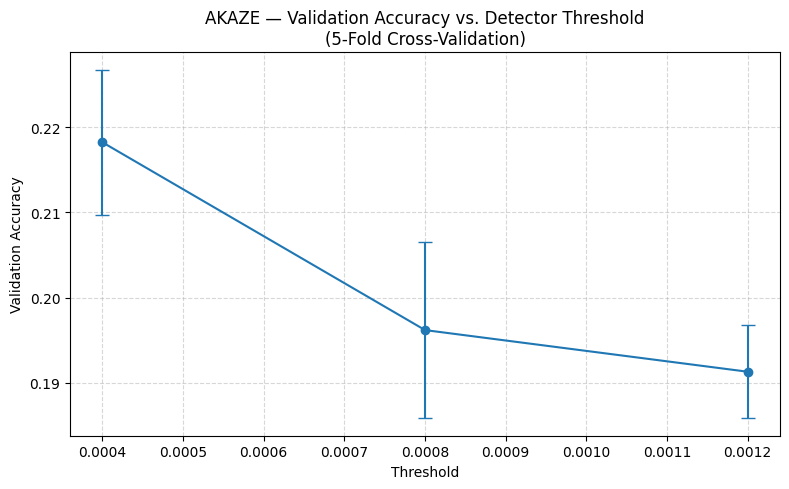

In [26]:
# Plot AKAZE Validation Accuracy vs nFeatures (5-Fold CV)

# Since the dataset is reasonably balanced and we use stratified 5-fold cross-validation, 
# accuracy is a reliable metric for evaluating performance in this experiment.

akaze_thresholds = akaze_threshold

# Accuracy from CV results
acc_means = [akaze_results[t].test.accuracy.mean for t in akaze_thresholds]
acc_stds  = [akaze_results[t].test.accuracy.std for t in akaze_thresholds]

plt.figure(figsize=(8, 5))
plt.errorbar(akaze_thresholds, acc_means, yerr=acc_stds,
             marker='o', capsize=5)

plt.title("AKAZE — Validation Accuracy vs. Detector Threshold\n(5-Fold Cross-Validation)")
plt.xlabel("Threshold")
plt.ylabel("Validation Accuracy")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


In [27]:
# Tested on the held-out test set using the best threshold selected by cross-validation (0.0004)
bovw_params = {
    "detector_type": "AKAZE",
    "codebook_size": 512,
    "detector_kwargs": {"threshold": 0.0004},
}

classifier_cls = LogisticRegression
classifier_params = {
    "max_iter": 1000,
    "class_weight": "balanced",
}
bovw = BOVW(**bovw_params)
classifier = classifier_cls(**classifier_params)
bovw, classifier = train(dataset=data_train, bovw=bovw, classifier=classifier)

test(dataset=data_test, bovw=bovw, classifier=classifier)

Phase [Training]: Extracting the descriptors: 100%|██████████| 8700/8700 [00:09<00:00, 920.23it/s] 


Fitting the codebook
Computing the bovw histograms
Fitting the classifier
Accuracy on Phase[Train]: 0.3526975727596917
Precision on Phase[Train]: 0.35211372286773507
Recall on Phase[Train]: 0.3526975727596917
F1-Score on Phase[Train]: 0.3487348108259699


Phase [Eval]: Extracting the descriptors: 100%|██████████| 2200/2200 [00:45<00:00, 48.87it/s]


Computing the bovw histograms
predicting the values
Accuracy on Phase[Test]: 0.21409090909090908
Precision on Phase[Test]: 0.20484089062217142
Recall on Phase[Test]: 0.21409090909090908
F1-Score on Phase[Test]: 0.20675398563017028


(0.21409090909090908,
 0.20484089062217142,
 0.21409090909090908,
 0.20675398563017028)

### ORB

In [28]:
# ORB
print("TESTING ORB DESCRIPTOR")

orb_nfeatures = [250, 500, 1000, 2000, 10000]
orb_results = {}

for nfeatures in orb_nfeatures:
    print(f"\nORB with nfeatures={nfeatures}")
    
    bovw_params = {
        "detector_type": "ORB",
        "codebook_size": 512,
        "detector_kwargs": {"nfeatures": nfeatures},
    }
    
    classifier_cls = LogisticRegression
    classifier_params = {
        "max_iter": 1000,
        "class_weight": "balanced",
    }
    
    scores = cross_validate_bovw(
        data_train,
        bovw_kwargs=bovw_params,
        classifier_cls=classifier_cls,
        classifier_kwargs=classifier_params,
        n_splits=5,
        verbose=False,
    )
    
    orb_results[nfeatures] = scores
    
    print(f"[ORB nfeatures={nfeatures}] Results:")
    print(f"  Train Accuracy:  {scores.train.accuracy.mean:.4f} ± {scores.train.accuracy.std:.4f}")
    print(f"  Test Accuracy:   {scores.test.accuracy.mean:.4f} ± {scores.test.accuracy.std:.4f}")
    print(f"  Test Precision:  {scores.test.precision.mean:.4f} ± {scores.test.precision.std:.4f}")
    print(f"  Test Recall:     {scores.test.recall.mean:.4f} ± {scores.test.recall.std:.4f}")
    print(f"  Test F1-Score:   {scores.test.f1.mean:.4f} ± {scores.test.f1.std:.4f}")

print("\nORB SUMMARY")
for nfeatures in orb_nfeatures:
    print(f"nfeatures={nfeatures:4d} -> Accuracy Train: {orb_results[nfeatures].train.accuracy.mean:.4f} ± {orb_results[nfeatures].train.accuracy.std:.4f}")
    print(f"nfeatures={nfeatures:4d} -> Accuracy Test: {orb_results[nfeatures].test.accuracy.mean:.4f} ± {orb_results[nfeatures].test.accuracy.std:.4f}")
    print("")

TESTING ORB DESCRIPTOR

ORB with nfeatures=250


Phase [Setup]: Extracting the descriptors:   0%|          | 0/8700 [00:00<?, ?it/s]

Phase [Setup]: Extracting the descriptors:   6%|▌         | 539/8700 [00:04<00:43, 189.64it/s]

Could not compute descriptors for image ../data/places_reduced/train/water_ice_snow/iceberg_00000023.jpg of class 9.


Phase [Setup]: Extracting the descriptors:  12%|█▏        | 1066/8700 [00:07<00:41, 182.80it/s]

Could not compute descriptors for image ../data/places_reduced/train/mountains_hills_desert_sky/sky_00001410.jpg of class 5.


Phase [Setup]: Extracting the descriptors:  65%|██████▍   | 5624/8700 [00:36<00:18, 166.52it/s]

Could not compute descriptors for image ../data/places_reduced/train/sports and leisure/sauna_00001030.jpg of class 7.


100%|██████████| 5/5 [01:49<00:00, 21.82s/it]


[ORB nfeatures=250] Results:
  Train Accuracy:  0.3405 ± 0.0041
  Test Accuracy:   0.1732 ± 0.0101
  Test Precision:  0.1711 ± 0.0102
  Test Recall:     0.1732 ± 0.0101
  Test F1-Score:   0.1703 ± 0.0099

ORB with nfeatures=500


Phase [Setup]: Extracting the descriptors:   6%|▌         | 517/8700 [00:04<00:59, 136.94it/s]

Could not compute descriptors for image ../data/places_reduced/train/water_ice_snow/iceberg_00000023.jpg of class 9.


Phase [Setup]: Extracting the descriptors:  12%|█▏        | 1039/8700 [00:08<01:00, 126.26it/s]

Could not compute descriptors for image ../data/places_reduced/train/mountains_hills_desert_sky/sky_00001410.jpg of class 5.


Phase [Setup]: Extracting the descriptors:  64%|██████▍   | 5605/8700 [00:40<00:19, 155.66it/s]

Could not compute descriptors for image ../data/places_reduced/train/sports and leisure/sauna_00001030.jpg of class 7.


100%|██████████| 5/5 [02:24<00:00, 28.99s/it]


[ORB nfeatures=500] Results:
  Train Accuracy:  0.3395 ± 0.0052
  Test Accuracy:   0.1818 ± 0.0112
  Test Precision:  0.1762 ± 0.0110
  Test Recall:     0.1818 ± 0.0112
  Test F1-Score:   0.1771 ± 0.0110

ORB with nfeatures=1000


Phase [Setup]: Extracting the descriptors:   6%|▌         | 519/8700 [00:06<01:21, 100.23it/s]

Could not compute descriptors for image ../data/places_reduced/train/water_ice_snow/iceberg_00000023.jpg of class 9.


Phase [Setup]: Extracting the descriptors:  12%|█▏        | 1054/8700 [00:10<00:51, 148.20it/s]

Could not compute descriptors for image ../data/places_reduced/train/mountains_hills_desert_sky/sky_00001410.jpg of class 5.


Phase [Setup]: Extracting the descriptors:  64%|██████▍   | 5605/8700 [00:51<00:38, 80.83it/s] 

Could not compute descriptors for image ../data/places_reduced/train/sports and leisure/sauna_00001030.jpg of class 7.


100%|██████████| 5/5 [03:33<00:00, 42.66s/it]


[ORB nfeatures=1000] Results:
  Train Accuracy:  0.3408 ± 0.0052
  Test Accuracy:   0.1989 ± 0.0072
  Test Precision:  0.1942 ± 0.0081
  Test Recall:     0.1989 ± 0.0072
  Test F1-Score:   0.1939 ± 0.0080

ORB with nfeatures=2000


Phase [Setup]: Extracting the descriptors:   6%|▌         | 508/8700 [00:06<01:59, 68.83it/s] 

Could not compute descriptors for image ../data/places_reduced/train/water_ice_snow/iceberg_00000023.jpg of class 9.


Phase [Setup]: Extracting the descriptors:  12%|█▏        | 1028/8700 [00:13<02:05, 61.31it/s]

Could not compute descriptors for image ../data/places_reduced/train/mountains_hills_desert_sky/sky_00001410.jpg of class 5.


Phase [Setup]: Extracting the descriptors:  64%|██████▍   | 5608/8700 [01:10<01:18, 39.53it/s] 

Could not compute descriptors for image ../data/places_reduced/train/sports and leisure/sauna_00001030.jpg of class 7.


100%|██████████| 5/5 [05:43<00:00, 68.64s/it]


[ORB nfeatures=2000] Results:
  Train Accuracy:  0.3383 ± 0.0033
  Test Accuracy:   0.2171 ± 0.0039
  Test Precision:  0.2145 ± 0.0039
  Test Recall:     0.2171 ± 0.0039
  Test F1-Score:   0.2113 ± 0.0027

ORB with nfeatures=10000


Phase [Setup]: Extracting the descriptors:   6%|▌         | 508/8700 [00:08<02:07, 64.08it/s]

Could not compute descriptors for image ../data/places_reduced/train/water_ice_snow/iceberg_00000023.jpg of class 9.


Phase [Setup]: Extracting the descriptors:  12%|█▏        | 1037/8700 [00:15<01:46, 72.26it/s]

Could not compute descriptors for image ../data/places_reduced/train/mountains_hills_desert_sky/sky_00001410.jpg of class 5.


Phase [Setup]: Extracting the descriptors:  64%|██████▍   | 5611/8700 [01:22<00:34, 88.77it/s] 

Could not compute descriptors for image ../data/places_reduced/train/sports and leisure/sauna_00001030.jpg of class 7.


100%|██████████| 5/5 [08:27<00:00, 101.46s/it]


[ORB nfeatures=10000] Results:
  Train Accuracy:  0.3478 ± 0.0034
  Test Accuracy:   0.2304 ± 0.0128
  Test Precision:  0.2256 ± 0.0144
  Test Recall:     0.2304 ± 0.0128
  Test F1-Score:   0.2222 ± 0.0124

ORB SUMMARY
nfeatures= 250 -> Accuracy Train: 0.3405 ± 0.0041
nfeatures= 250 -> Accuracy Test: 0.1732 ± 0.0101

nfeatures= 500 -> Accuracy Train: 0.3395 ± 0.0052
nfeatures= 500 -> Accuracy Test: 0.1818 ± 0.0112

nfeatures=1000 -> Accuracy Train: 0.3408 ± 0.0052
nfeatures=1000 -> Accuracy Test: 0.1989 ± 0.0072

nfeatures=2000 -> Accuracy Train: 0.3383 ± 0.0033
nfeatures=2000 -> Accuracy Test: 0.2171 ± 0.0039

nfeatures=10000 -> Accuracy Train: 0.3478 ± 0.0034
nfeatures=10000 -> Accuracy Test: 0.2304 ± 0.0128



ORB SUMMARY
- nfeatures= 250 -> Accuracy Train: 0.3405 ± 0.0041
- nfeatures= 250 -> Accuracy Test: 0.1732 ± 0.0101

- nfeatures= 500 -> Accuracy Train: 0.3395 ± 0.0052
- nfeatures= 500 -> Accuracy Test: 0.1818 ± 0.0112

- nfeatures=1000 -> Accuracy Train: 0.3408 ± 0.0052
- nfeatures=1000 -> Accuracy Test: 0.1989 ± 0.0072

- nfeatures=2000 -> Accuracy Train: 0.3383 ± 0.0033
- nfeatures=2000 -> Accuracy Test: 0.2171 ± 0.0039

- nfeatures=10000 -> Accuracy Train: 0.3478 ± 0.0034
- nfeatures=10000 -> Accuracy Test: 0.2304 ± 0.0128

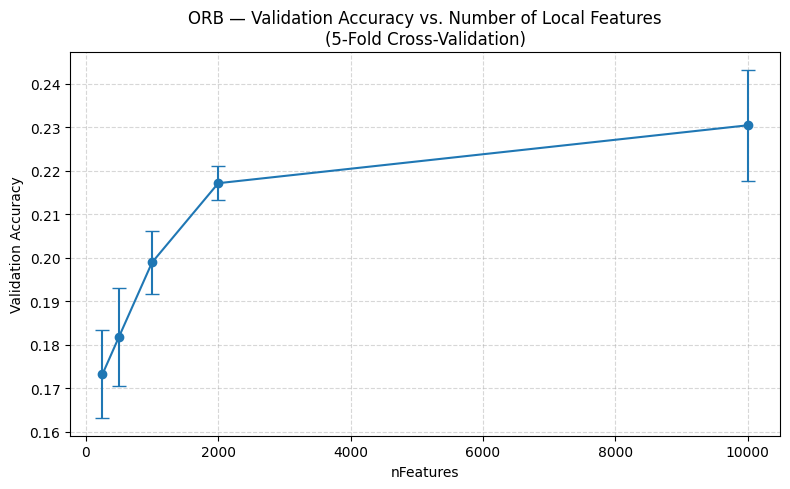

In [ ]:
# Plot ORB Validation Accuracy vs nFeatures (5-Fold CV)

# Since the dataset is reasonably balanced and we use stratified 5-fold cross-validation, 
# accuracy is a reliable metric for evaluating performance in this experiment.
n_features = orb_nfeatures

# Accuracy
acc_means = [orb_results[n].test.accuracy.mean for n in n_features]
acc_stds  = [orb_results[n].test.accuracy.std for n in n_features]}

plt.figure(figsize=(8, 5))
plt.errorbar(n_features, acc_means, yerr=acc_stds,
             marker='o', capsize=5)

plt.title("ORB — Validation Accuracy vs. Number of Local Features\n(5-Fold Cross-Validation)")
plt.xlabel("nFeatures")
plt.ylabel("Validation Accuracy")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


In [31]:
# Tested on the held-out test set using the best nFeatures selected by cross-validation (1000)
bovw_params = {
    "detector_type": "ORB",
    "codebook_size": 512,
    "detector_kwargs": {"nfeatures": 1000},
}

classifier_cls = LogisticRegression
classifier_params = {
    "max_iter": 1000,
    "class_weight": "balanced",
}
bovw = BOVW(**bovw_params)
classifier = classifier_cls(**classifier_params)
bovw, classifier = train(dataset=data_train, bovw=bovw, classifier=classifier)

test(dataset=data_test, bovw=bovw, classifier=classifier)

Phase [Training]: Extracting the descriptors: 100%|██████████| 8700/8700 [00:19<00:00, 437.57it/s]


Fitting the codebook
Computing the bovw histograms
Fitting the classifier
Accuracy on Phase[Train]: 0.32677934920087387
Precision on Phase[Train]: 0.32634404383890975
Recall on Phase[Train]: 0.32677934920087387
F1-Score on Phase[Train]: 0.32265218617154756


Phase [Eval]: Extracting the descriptors: 100%|██████████| 2200/2200 [00:20<00:00, 109.74it/s]


Computing the bovw histograms
predicting the values
Accuracy on Phase[Test]: 0.19318181818181818
Precision on Phase[Test]: 0.18980563152134505
Recall on Phase[Test]: 0.19318181818181818
F1-Score on Phase[Test]: 0.18901878628542151


(0.19318181818181818,
 0.18980563152134505,
 0.19318181818181818,
 0.18901878628542151)

## Comparison and Best Configuration

Comparing all three descriptors across different feature counts to select the best for further experimentation.

In [32]:
# Comparison of all descriptors
print("SECTION A: FINAL COMPARISON - DESCRIPTORS AND NUMBER OF FEATURES")

# Prepare comparison data
comparison_data = []

for nfeatures in sift_nfeatures:
    comparison_data.append({
        "Descriptor": "SIFT",
        "nfeatures": nfeatures,
        "Train Acc": sift_results[nfeatures].train.accuracy.mean,
        "Test Acc": sift_results[nfeatures].test.accuracy.mean,
        "Test Acc Std": sift_results[nfeatures].test.accuracy.std,
        "Test Prec": sift_results[nfeatures].test.precision.mean,
        "Test Rec": sift_results[nfeatures].test.recall.mean,
        "Test F1": sift_results[nfeatures].test.f1.mean,
    })

for threshold in akaze_thresholds:
    comparison_data.append({
        "Descriptor": "AKAZE",
        "nfeatures": threshold,
        "Train Acc": akaze_results[threshold].train.accuracy.mean,
        "Test Acc": akaze_results[threshold].test.accuracy.mean,
        "Test Acc Std": akaze_results[threshold].test.accuracy.std,
        "Test Prec": akaze_results[threshold].test.precision.mean,
        "Test Rec": akaze_results[threshold].test.recall.mean,
        "Test F1": akaze_results[threshold].test.f1.mean,
    })

for nfeatures in orb_nfeatures:
    comparison_data.append({
        "Descriptor": "ORB",
        "nfeatures": nfeatures,
        "Train Acc": orb_results[nfeatures].train.accuracy.mean,
        "Test Acc": orb_results[nfeatures].test.accuracy.mean,
        "Test Acc Std": orb_results[nfeatures].test.accuracy.std,
        "Test Prec": orb_results[nfeatures].test.precision.mean,
        "Test Rec": orb_results[nfeatures].test.recall.mean,
        "Test F1": orb_results[nfeatures].test.f1.mean,
    })

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

# Find best configuration
best_idx = comparison_df["Test Acc"].idxmax()
best_config = comparison_df.loc[best_idx]

print("\n" + "=" * 80)
print("BEST CONFIGURATION FOR SECTION A")
print("=" * 80)
print(f"Descriptor: {best_config['Descriptor']}")
print(f"Number of Features: {best_config['nfeatures']}")
print(f"Test Accuracy: {best_config['Test Acc']:.4f} ± {best_config['Test Acc Std']:.4f}")
print(f"Test Precision: {best_config['Test Prec']:.4f}")
print(f"Test Recall: {best_config['Test Rec']:.4f}")
print(f"Test F1-Score: {best_config['Test F1']:.4f}")

# Recommendation for next section
best_descriptor = best_config['Descriptor']
best_nfeatures = int(best_config['nfeatures'])
print(f"\nRecommendation for next sections: Use {best_descriptor} with nfeatures={best_nfeatures}")

SECTION A: FINAL COMPARISON - DESCRIPTORS AND NUMBER OF FEATURES
Descriptor  nfeatures  Train Acc  Test Acc  Test Acc Std  Test Prec  Test Rec  Test F1
      SIFT   250.0000   0.436078  0.292940      0.008526   0.284127  0.292940 0.285502
      SIFT   500.0000   0.442286  0.318118      0.004848   0.310067  0.318118 0.310588
      SIFT  1000.0000   0.448206  0.332376      0.007330   0.323406  0.332376 0.324510
      SIFT  2000.0000   0.446223  0.331455      0.008186   0.321544  0.331455 0.322747
      SIFT 10000.0000   0.451943  0.327546      0.003740   0.320165  0.327546 0.320248
     AKAZE     0.0004   0.368227  0.218220      0.008538   0.213997  0.218220 0.213403
     AKAZE     0.0008   0.365790  0.196176      0.010353   0.190583  0.196176 0.191155
     AKAZE     0.0012   0.355871  0.191288      0.005446   0.184302  0.191288 0.185282
       ORB   250.0000   0.340520  0.173164      0.010071   0.171057  0.173164 0.170262
       ORB   500.0000   0.339542  0.181788      0.011161   0.1762

## B) Density vs Non Density (SIFT vs Dense SIFT)

Since SIFT was the best performing descriptor in the previous experiment, we now compare keypoint-based SIFT with Dense SIFT to evaluate whether dense sampling can improve scene recognition performance. In particular, we aim to answer:

* Does Dense SIFT outperform standard SIFT in this context?

* How does the step size (sampling density) affect performance and computation time?

* Does the scale used for descriptor extraction influence the results?

In this experiment, we first fix the descriptor scale and vary the step size to study the effect of sampling density. Then, we fix the "best" step size and evaluate different scales to analyze whether scale impacts performance. This allows us to isolate the influence of each factor and fairly assess the benefits of Dense SIFT over standard keypoint-based SIFT.

In [13]:
def dense_keypoints_grid(img_shape, step, scale):
    h, w = img_shape[:2]
    keypoints = []
    for y in range(0, h, step):
        for x in range(0, w, step):
            keypoints.append(cv2.KeyPoint(x=float(x), y=float(y), size=float(scale)))
    return keypoints

def show_dense_sift(img, step, scale, title=""):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    kps = dense_keypoints_grid(gray.shape, step=step, scale=scale)
    img_kps = cv2.drawKeypoints(img, kps, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    plt.imshow(img_kps)
    plt.axis("off")
    plt.title(f"{title}\nstep={step}, scale={scale}")

### Step Size Evaluation

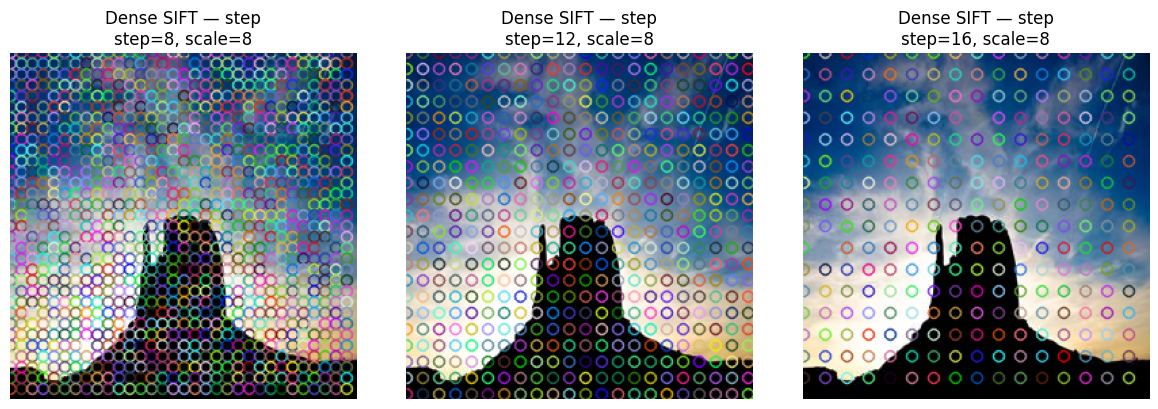

In [14]:
steps = [8, 12, 16]
scale = 8

sample_idx = 70
img = np.array(data_train[sample_idx][0])

plt.figure(figsize=(16, 4))
for i, s in enumerate(steps, 1):
    plt.subplot(1, 4, i)
    show_dense_sift(img, step=s, scale=scale, title="Dense SIFT — step")
plt.tight_layout()
plt.show()


In [16]:
# DENSE SIFT — STEP SIZE EXPERIMENT
print("TESTING DENSE SIFT (VARYING STEP SIZE)")

dense_steps = [8, 12, 16]   
dense_scale = 8            
dense_results = {}

for step in dense_steps:
    print(f"\nDense SIFT with step={step}, scale={dense_scale}")
    
    bovw_params = {
        "detector_type": "DSIFT",          
        "codebook_size": 512,
        "dense_kwargs": {
            "step": step,
            "scale": dense_scale,
        },
    }
    
    classifier_cls = LogisticRegression
    classifier_params = {
        "max_iter": 1000,
        "class_weight": "balanced",
    }
    
    scores = cross_validate_bovw(
        data_train,
        bovw_kwargs=bovw_params,
        classifier_cls=classifier_cls,
        classifier_kwargs=classifier_params,
        n_splits=5,
        verbose=False,
    )
    
    dense_results[step] = scores
    
    print(f"[Dense SIFT step={step}] Results:")
    print(f"  Train Accuracy:  {scores.train.accuracy.mean:.4f} ± {scores.train.accuracy.std:.4f}")
    print(f"  Test Accuracy:   {scores.test.accuracy.mean:.4f} ± {scores.test.accuracy.std:.4f}")
    print(f"  Test Precision:  {scores.test.precision.mean:.4f} ± {scores.test.precision.std:.4f}")
    print(f"  Test Recall:     {scores.test.recall.mean:.4f} ± {scores.test.recall.std:.4f}")
    print(f"  Test F1-Score:   {scores.test.f1.mean:.4f} ± {scores.test.f1.std:.4f}")

print("\nDENSE SIFT (STEP) SUMMARY")
for step in dense_steps:
    print(f"step={step:2d} -> Accuracy Train: {dense_results[step].train.accuracy.mean:.4f} ± {dense_results[step].train.accuracy.std:.4f}")
    print(f"step={step:2d} -> Accuracy Test:  {dense_results[step].test.accuracy.mean:.4f} ± {dense_results[step].test.accuracy.std:.4f}")
    print("")


TESTING DENSE SIFT (VARYING STEP SIZE)

Dense SIFT with step=8, scale=8


Phase [Setup]: Extracting the descriptors:   0%|          | 0/8700 [00:00<?, ?it/s]

100%|██████████| 5/5 [05:03<00:00, 60.72s/it]


[Dense SIFT step=8] Results:
  Train Accuracy:  0.4203 ± 0.0070
  Test Accuracy:   0.3268 ± 0.0098
  Test Precision:  0.3185 ± 0.0080
  Test Recall:     0.3268 ± 0.0098
  Test F1-Score:   0.3173 ± 0.0083

Dense SIFT with step=12, scale=8


100%|██████████| 5/5 [03:08<00:00, 37.68s/it]


[Dense SIFT step=12] Results:
  Train Accuracy:  0.4212 ± 0.0052
  Test Accuracy:   0.3077 ± 0.0139
  Test Precision:  0.2994 ± 0.0133
  Test Recall:     0.3077 ± 0.0139
  Test F1-Score:   0.2987 ± 0.0129

Dense SIFT with step=16, scale=8


100%|██████████| 5/5 [02:17<00:00, 27.48s/it]

[Dense SIFT step=16] Results:
  Train Accuracy:  0.4304 ± 0.0059
  Test Accuracy:   0.2867 ± 0.0116
  Test Precision:  0.2778 ± 0.0114
  Test Recall:     0.2867 ± 0.0116
  Test F1-Score:   0.2781 ± 0.0117

DENSE SIFT (STEP) SUMMARY
step= 8 -> Accuracy Train: 0.4203 ± 0.0070
step= 8 -> Accuracy Test:  0.3268 ± 0.0098

step=12 -> Accuracy Train: 0.4212 ± 0.0052
step=12 -> Accuracy Test:  0.3077 ± 0.0139

step=16 -> Accuracy Train: 0.4304 ± 0.0059
step=16 -> Accuracy Test:  0.2867 ± 0.0116



DENSE SIFT (STEP) SUMMARY
- step= 8 -> Accuracy Train: 0.4203 ± 0.0070
- step= 8 -> Accuracy Test:  0.3268 ± 0.0098

- step=12 -> Accuracy Train: 0.4212 ± 0.0052
- step=12 -> Accuracy Test:  0.3077 ± 0.0139

- step=16 -> Accuracy Train: 0.4304 ± 0.0059
- step=16 -> Accuracy Test:  0.2867 ± 0.0116

### Scale Size Evaluation

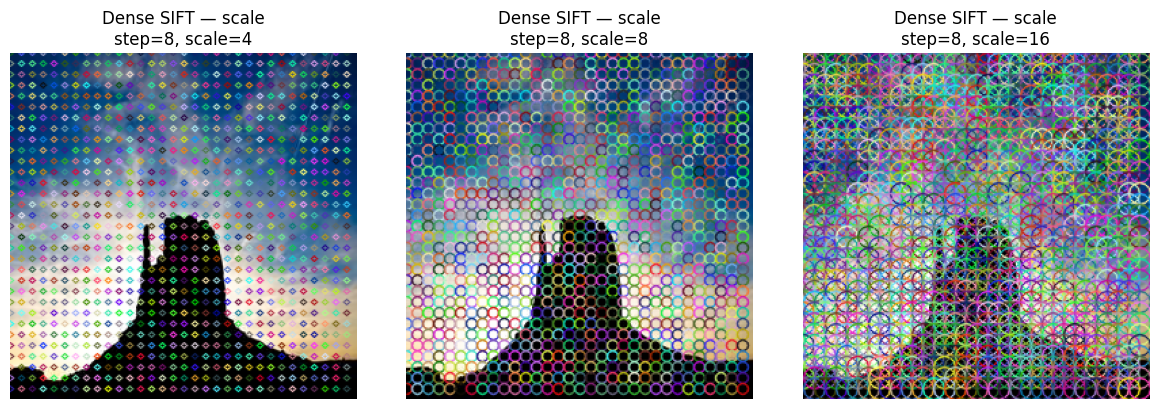

In [17]:
step = 8
scales = [4, 8, 16]

sample_idx = 70
img = np.array(data_train[sample_idx][0])

plt.figure(figsize=(16, 4))
for i, sc in enumerate(scales, 1):
    plt.subplot(1, 4, i)
    show_dense_sift(img, step=step, scale=sc, title="Dense SIFT — scale")
plt.tight_layout()
plt.show()

In [ ]:
# DENSE SIFT — SCALE SIZE EXPERIMENT
print("TESTING DENSE SIFT (VARYING SCALE SIZE)")

dense_step = 8   
dense_scales = [4, 8, 16]            
dense_results = {}

for scale in dense_scales:
    print(f"\nDense SIFT with step={dense_step}, scale={scale}")
    
    bovw_params = {
        "detector_type": "DSIFT",          
        "codebook_size": 512,
        "dense_kwargs": {
            "step": dense_step,
            "scale": scale,
        },
    }
    
    classifier_cls = LogisticRegression
    classifier_params = {
        "max_iter": 1000,
        "class_weight": "balanced",
    }
    
    scores = cross_validate_bovw(
        data_train,
        bovw_kwargs=bovw_params,
        classifier_cls=classifier_cls,
        classifier_kwargs=classifier_params,
        n_splits=5,
        verbose=False,
    )
    
    dense_results[scale] = scores
    
    print(f"[Dense SIFT step={dense_step}, scale={scale}] Results:")
    print(f"  Train Accuracy:  {scores.train.accuracy.mean:.4f} ± {scores.train.accuracy.std:.4f}")
    print(f"  Test Accuracy:   {scores.test.accuracy.mean:.4f} ± {scores.test.accuracy.std:.4f}")
    print(f"  Test Precision:  {scores.test.precision.mean:.4f} ± {scores.test.precision.std:.4f}")
    print(f"  Test Recall:     {scores.test.recall.mean:.4f} ± {scores.test.recall.std:.4f}")
    print(f"  Test F1-Score:   {scores.test.f1.mean:.4f} ± {scores.test.f1.std:.4f}")

print("\nDENSE SIFT (SCALE) SUMMARY")
for scale in dense_scales:
    print(f"scale={scale:2d} -> Accuracy Train: {dense_results[scale].train.accuracy.mean:.4f} ± {dense_results[scale].train.accuracy.std:.4f}")
    print(f"scale={scale:2d} -> Accuracy Test:  {dense_results[scale].test.accuracy.mean:.4f} ± {dense_results[scale].test.accuracy.std:.4f}")
    print("")


## C) Size of codebook

Try for different codebook sizes (k) 

In [ ]:
enable_cache()

## D) Spatial Pyramids

Comaprision between using and not using spatial pyramids

## E) Classifiers and Normalization

Since the way the data is normalized and preprocessed can depend on the classifier, we're going to try this along the different classifiers and it's hyperparameter search for Logistic Regression, SVM, KNN

## F) Dimensionality Reduction

We're going to try PCA, SVD, LDA, t-SNE

## G) Fisher Vectors

Finally, we're going to do a fisher vector approach